In [40]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from metrics import metrics

In [41]:
RS = 42

In [42]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("present", axis=1)
data.head()

,e_Vmag,Bmag,e_Bmag,gpmag,e_gpmag,rpmag,e_rpmag,ipmag,e_ipmag,fuv_mag,nuv_mag,err,type,min_mag,max_mag
0,0.033,11.080,0.024,13.351,3.579,12.599,3.330,10.066,0.031,22.017,15.786,4.888841,NaN,NaN,NaN
1,0.053,14.767,0.040,14.272,0.209,15.754,4.109,13.373,0.773,23.920,19.509,4.186825,NaN,NaN,NaN
2,0.046,12.909,0.045,12.494,0.197,14.430,3.722,11.920,0.520,23.090,16.583,3.763859,NaN,NaN,NaN
3,0.041,14.127,0.041,13.766,0.181,15.375,3.672,13.049,0.672,24.091,17.881,3.737819,NaN,NaN,NaN
4,0.077,14.042,0.048,13.634,0.208,15.422,3.632,13.227,0.000,22.714,17.651,3.639082,RS,13.29,13.41


In [43]:
eruptive_keywords = [
    "FU", "GCAS", "IN", "RCB", "SDOR", "UV", "WR", "RS", "TTAU", "FLARE"
]

pulsating_keywords = [
    "CEP", "CW", "DCEP", "DSCT", "M", "MIRA", "RR", "RV", "SR", 
    "SRA", "SRB", "SRC", "SRD", "BCEP", "ZZ", "ACYG", "SXPHE", "PVTEL", "BLBOO"
]

rotating_keywords = [
    "ROT", "BY", "ELL", "ACV", "FKCOM", "SXARI", "PSR"
]

eclipsing_keywords = [
    "E", "EA", "EB", "EW", "EC", "EL", "ALGOL", "BLYR", "WUMA"
]

In [44]:
def classify_type(vtype: str) -> str:
    """
    Возвращает укрупнённый класс переменной звезды
    в зависимости от содержимого строки vtype.
    """

    if pd.isna(vtype) or not isinstance(vtype, str) or vtype.strip() == "":
        return "UNKNOWN"  # Или "UNKNOWN", если хотите отдельно отметить NaN и пустые

    # Приведём к верхнему регистру для надёжного поиска подстрок
    t = vtype.upper()

    # --- 1) Затменные (Eclipsing Binaries) ---
    # Ищем любые подтипы: EA, EB, EW, EC, ELL, E/RS и т.д.
    # Включим также "E|" (встречается в комбинированных типах) и просто "E" (бывает)
    ecl_markers = ["EA", "EB", "EW", "EC", "ELL", "E/RS", "E|", "E "]
    if any(m in t for m in ecl_markers):
        return "ECLIPSING"

    # --- 2) Цефеиды и родственные (DCEP, CW, RV Tauri, ACEP) ---
    cep_markers = ["DCEP", "CW-FU", "CW", "CWA", "CWB", "RVA", "RV", "ACEP", "CEP"]
    # Примечание: "RV" может пересекаться с "RVC", "ROT" и пр.,
    # поэтому в реальном коде можно уточнять условия, но здесь — упрощённо.
    if any(m in t for m in cep_markers):
        return "CEPHEIDS"

    # --- 3) RR Лиры (RRAB, RRC, RRD, RR...) ---
    rr_markers = ["RRAB", "RRC", "RRD", "RR"]
    if any(m in t for m in rr_markers):
        return "RR_LYRAE"

    # --- 4) Короткопериодические пульсаторы: DSCT, SXPHE, GDOR, roAp ---
    short_puls = ["DSCT", "HADS", "SXPHE", "GDOR", "ROAP", "ROAM"]
    if any(m in t for m in short_puls):
        return "DELTA_SCUTI_ETC"

    # --- 5) Долгопериодические и полуправильные (M, SR, L) ---
    # Mira (M), SR, SRA, SRB, SRC, SRD, L, LB, LC, LPV
    lpv_markers = [" M ", "MIRA", "SR", "SRA", "SRB", "SRC", "SRD", "L ", "LB", "LC", "LPV"]
    # Для "M" можно проверять отдельно, чтобы не совпадало с "MISC", поэтому " M " с пробелами,
    # но тут для упрощения — любой "M". В реальном коде нужна аккуратность или RegEx.
    if any(m in t for m in lpv_markers):
        return "LONG_PERIOD"

    # --- 6) Ротационные переменные (BY, RS, ACV, SPB, ROT, GCAS) ---
    rot_markers = ["BY", "RS", "ACV", "SPB", "ROT", "GCAS"]
    if any(m in t for m in rot_markers):
        return "ROTATIONAL"

    # --- 7) Эруптивные/молодые звёзды (T Tauri, EXOR, UXOR, INS...) ---
    yso_markers = ["TTS", "EXOR", "UXOR", "INS", "IN", "INST", "CST"]  
    # "CST" иногда "constant?", но бывает и у молодых/неясных
    if any(m in t for m in yso_markers):
        return "YSO/ERUPTIVE"

    # --- Катаклизмические (UG, NL, AM, ZAND, IB, IS, ... ) ---
    cataclysmic_markers = ["UG", "NL", "AM", "ZAND", "IB", "ISB"]  # и др.
    if any(m in t for m in cataclysmic_markers):
        return "CATACLYSMIC"

    # --- 9) Горячие эмиссионные/WR/Be/симбиотические (WR, BE, FSCMa...) ---
    em_markers = ["WR", "BE", "FSCMA"]
    if any(m in t for m in em_markers):
        return "EMISSION_WR"

    # Если ничего не подошло, отправляем в "MISC" или "HYBRID"
    return "UNKNOWN"


# Теперь создаём новую колонку:
data["class"] = data["type"].apply(classify_type)
data.drop("type", axis=1, inplace=True)

# убрать "YSO/ERUPTIVE" и "EMISSION_WR"
data = data[(data['class'] != 'YSO/ERUPTIVE') & (data['class'] != 'EMISSION_WR')]

classes = data["class"].unique()

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop("class", axis=1), data["class"], random_state=RS, train_size=0.8)
display(X_train.head())
display(Y_train.head())

,e_Vmag,Bmag,e_Bmag,gpmag,e_gpmag,rpmag,e_rpmag,ipmag,e_ipmag,fuv_mag,nuv_mag,err,min_mag,max_mag
861,0.030,12.862,0.075,12.814,0.813,12.144,0.079,12.103,0.167,23.381,16.735,0.837630,8.33,0.95
57090,0.021,13.062,0.026,12.774,0.021,12.452,0.038,12.384,0.039,22.429,16.166,0.067253,14.43,14.46
41920,0.025,15.552,0.035,15.192,0.064,14.840,0.060,14.717,0.034,23.813,19.516,0.103450,13.10,0.34
14946,0.032,15.913,0.096,15.573,0.067,15.033,0.020,14.898,0.155,23.372,20.399,0.197874,13.43,0.18
7503,0.057,17.109,0.139,16.633,0.101,15.971,0.068,15.652,0.207,23.181,22.673,0.283274,14.09,14.46


861      UNKNOWN
57090    UNKNOWN
41920    UNKNOWN
14946    UNKNOWN
7503     UNKNOWN
Name: class, dtype: object

                 precision    recall  f1-score   support

    CATACLYSMIC       0.00      0.00      0.00         0
       CEPHEIDS       0.00      0.00      0.00         0
DELTA_SCUTI_ETC       0.48      0.82      0.60       312
      ECLIPSING       0.26      0.76      0.39        58
    LONG_PERIOD       0.09      1.00      0.17         1
     ROTATIONAL       0.26      0.83      0.40       103
       RR_LYRAE       0.59      0.79      0.67        72
        UNKNOWN       0.99      0.95      0.97     12452

       accuracy                           0.94     12998
      macro avg       0.33      0.64      0.40     12998
   weighted avg       0.97      0.94      0.95     12998



/home/c0c0nut/projects/Stellar-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/c0c0nut/projects/Stellar-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/c0c0nut/projects/Stellar-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

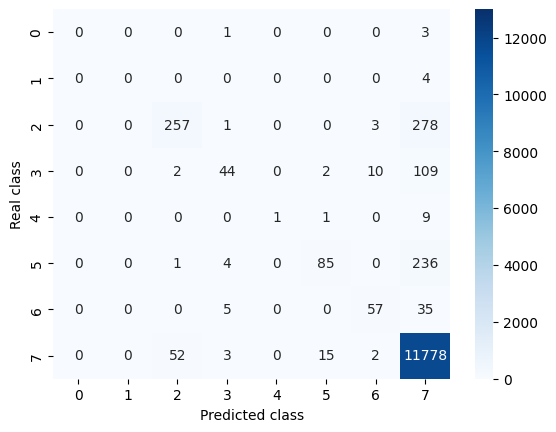

In [46]:
clf = RandomForestClassifier(n_estimators=100, max_depth=24, random_state=42)
clf.fit(X_train, Y_train)

# Evaluate
pred = clf.predict(X_test)
metrics(pred, Y_test, output=True, to_return=False)

                 precision    recall  f1-score   support

    CATACLYSMIC       1.00      1.00      1.00         5
       CEPHEIDS       1.00      1.00      1.00        13
DELTA_SCUTI_ETC       1.00      1.00      1.00      2009
      ECLIPSING       1.00      1.00      1.00       738
    LONG_PERIOD       1.00      1.00      1.00        34
     ROTATIONAL       1.00      1.00      1.00      1381
       RR_LYRAE       1.00      1.00      1.00       389
        UNKNOWN       1.00      1.00      1.00     47421

       accuracy                           1.00     51990
      macro avg       1.00      1.00      1.00     51990
   weighted avg       1.00      1.00      1.00     51990



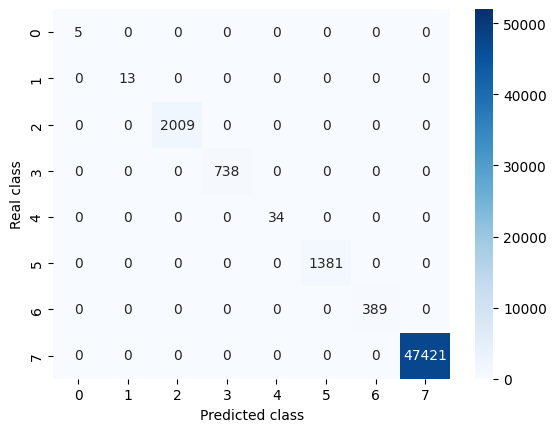

In [47]:
pred = clf.predict(X_train)
metrics(pred, Y_train, output=True, to_return=False)

                 precision    recall  f1-score   support

    CATACLYSMIC       0.00      0.00      0.00         0
       CEPHEIDS       0.00      0.00      0.00         0
DELTA_SCUTI_ETC       0.48      0.99      0.64       260
      ECLIPSING       0.26      0.80      0.40        55
    LONG_PERIOD       0.09      1.00      0.17         1
     ROTATIONAL       0.26      0.97      0.41        88
       RR_LYRAE       0.59      0.81      0.68        70
        UNKNOWN       0.00      0.00      0.00       674

       accuracy                           0.39      1148
      macro avg       0.21      0.57      0.29      1148
   weighted avg       0.18      0.39      0.24      1148



/home/c0c0nut/projects/Stellar-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/c0c0nut/projects/Stellar-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/c0c0nut/projects/Stellar-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

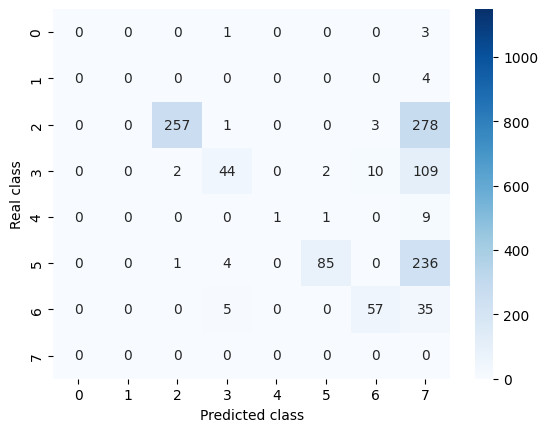

In [54]:
def drop_unknown(x, y):
  df = pd.concat([x, y], axis=1)
  df = df[df["class"] != "UNKNOWN"]
  return df

df = drop_unknown(X_test, Y_test)
X_test_1 = df.iloc[:, :-1]
Y_test_1 = df["class"]
pred = clf.predict(X_test_1)
metrics(pred, Y_test_1, output=True, to_return=False)